In [32]:
# -*- coding: utf-8 -*-
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
import warnings
from sklearn.metrics import r2_score
import pandas.tseries

import pandas as pd
import numpy as np
from scipy import stats

import statsmodels.api as sm

def invboxcox(x, lmbda = 0):
    if lmbda == 0:
        return(np.exp(x))
    else:
        return(np.exp(np.log(lmbda * x + 1) / lmbda))

In [33]:
def statTest(dataset, flag):
    test = sm.tsa.adfuller(dataset.iloc[:,0].values, autolag='AIC' )
    if test[0] > test[4]['5%']:
        if (flag):
            print ('Есть единичные корни, ряд не стационарен')
        return False
    else:
        if (flag):
            print ('Единичных корней нет, ряд стационарен')
        return True

In [34]:
def iOrder(dataset):
    print_flag = 0
    order = 0
    while not statTest(dataset, print_flag):
        dataset = dataset.diff()
        dataset.dropna(inplace = True)
        order += 1
    return order

In [35]:
dataset = read_csv('training.csv',
                     ',',
                     index_col=['Date'],
                     parse_dates=['Date'],
                     dayfirst=True)

In [36]:
def plotMovingAverage(dataset, n):
    rolling_mean = dataset.rolling(window=n).mean()
    rolling_std = dataset.rolling(window=n).std()
    plt.figure(figsize=(15,7))
    plt.plot(rolling_mean, color = "g", label="Rolling mean trend. Size = {}".format(n))
    plt.plot(rolling_std, color = "grey", label="Rolling std. Size = {}".format(n))
    plt.plot(dataset.Value, label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

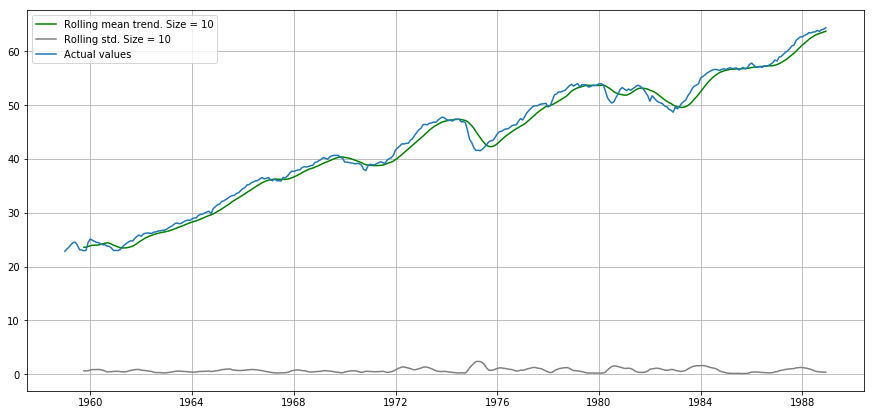

In [37]:
plotMovingAverage(dataset, 10)

In [38]:
statTest(dataset, 1)

Есть единичные корни, ряд не стационарен


False

# Разложение временного ряда на тренд, сезональность остаток в соответствии с аддитивной и мультипликативной моделями

In [39]:
def dfTest(dataset, flag):
    test = sm.tsa.adfuller(dataset)
    if test[0] > test[4]['10%']:
        if (flag):
            print ('есть единичные корни, ряд не стационарен')
        return False
    else:
        if (flag):
            print ('единичных корней нет, ряд стационарен')
        return True

In [40]:
def model(dataset, modelName):
    decomposition = seasonal_decompose(dataset.Value, model = modelName)    
    fig = plt.figure(figsize=(18,8))    
    tmp = decomposition.trend
    ax1 = fig.add_subplot(311)
    ax1.plot(tmp)
    ax1.set_title("Тренд")
    tmp.dropna(inplace=True)    
    print ('Tренд:', end=" ")
    dfTest(tmp, True)
    
    tmp = decomposition.seasonal
    ax2 = fig.add_subplot(312)
    ax2.plot(tmp)
    ax2.set_title('Сезональность')
    tmp.dropna(inplace=True)    
    print ('Сезональность:', end=" ")
    dfTest(tmp, True)
    
    tmp = decomposition.resid
    ax3 = fig.add_subplot(313)
    ax3.plot(tmp)
    ax3.set_title('Остаток')
    tmp.dropna(inplace=True)    
    print ('Остаток:', end=" ")
    dfTest(tmp, True)
    
    plt.show()

##  Аддитивная модель

Tренд: есть единичные корни, ряд не стационарен
Сезональность: единичных корней нет, ряд стационарен
Остаток: единичных корней нет, ряд стационарен


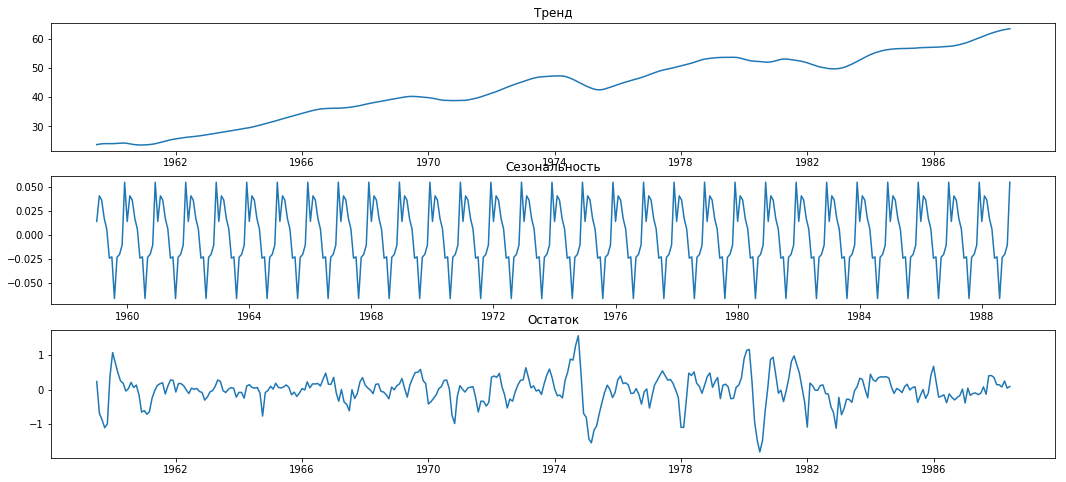

In [41]:
model(dataset, 'additive')

##  Мультипликативная модель

Tренд: есть единичные корни, ряд не стационарен
Сезональность: единичных корней нет, ряд стационарен
Остаток: единичных корней нет, ряд стационарен


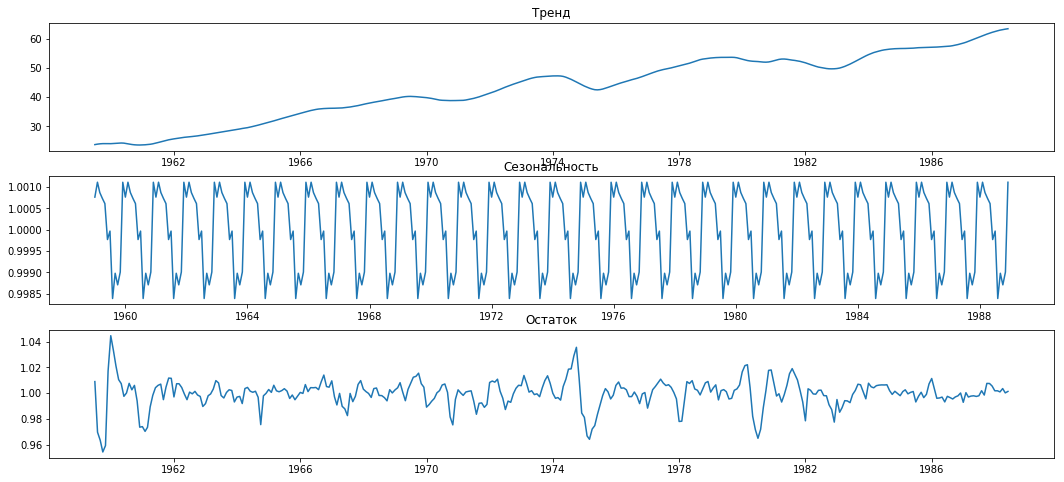

In [42]:
model(dataset, 'multiplicate')

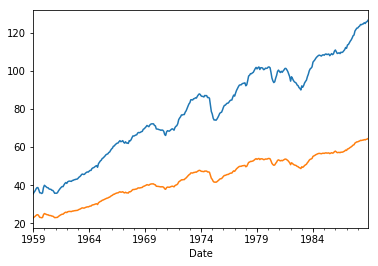

In [43]:
dataset['Value_box'], lmbda = stats.boxcox(dataset.Value)
dataset.Value_box.plot()
dataset.Value.plot()
plt.show()

Order of integration =  1


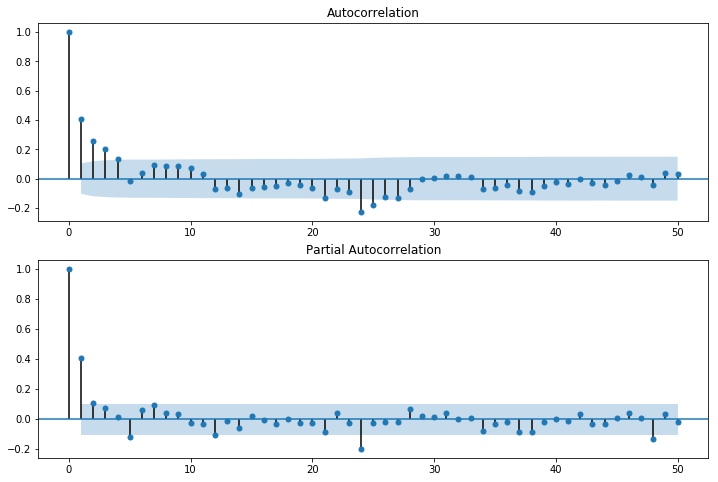

In [44]:
d = iOrder(dataset)
print ('Order of integration = ', d)

for i in range (0, d):
    dataset = dataset.diff()
    dataset.dropna(inplace = True)

lag_acf = acf(dataset.Value, nlags=50)
lag_pacf = pacf(dataset.Value, nlags=50, method='ols')

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset.Value, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset.Value, lags=50, ax=ax2)

plt.show()

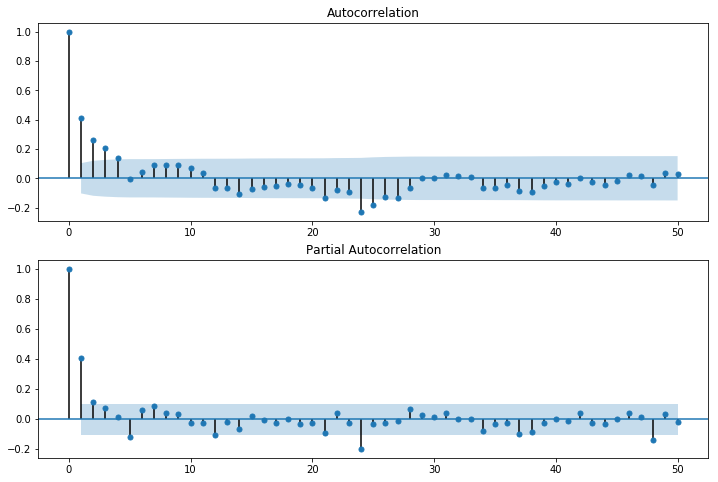

In [45]:
lag_acf = acf(dataset.Value_box, nlags=50)
lag_pacf = pacf(dataset.Value_box, nlags=50, method='ols')

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dataset.Value_box, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dataset.Value_box, lags=50, ax=ax2)

plt.show()

# Arima

In [46]:
dataset = read_csv('training.csv',
                     ',',
                     index_col=['Date'],
                     parse_dates=['Date'],
                     dayfirst=True)

In [47]:
datatest = read_csv('testing.csv',
                     ',',
                     index_col=['Date'],
                     parse_dates=['Date'],
                     dayfirst=True)

In [48]:
model = ARIMA(dataset.Value, order=(0, 1, 4)).fit(disp = -1)
print ('AIC =', model.aic)

AIC = 245.0053510782268


r2_score =  -2.41947017869


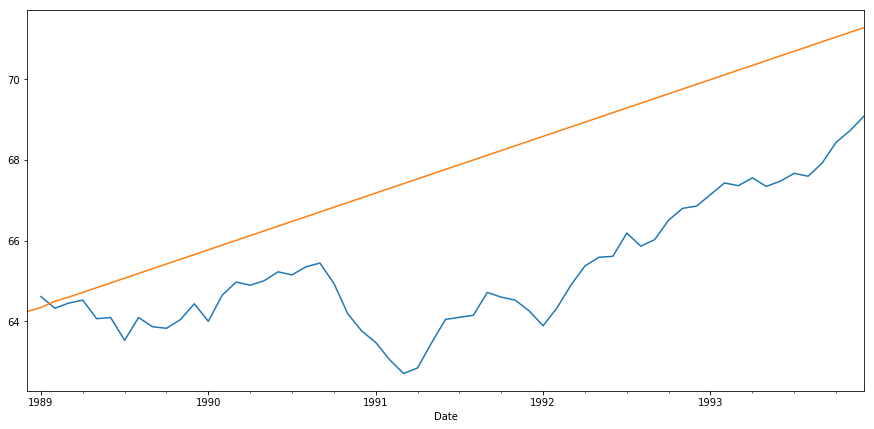

In [49]:
plt.figure(figsize=(15,7))
datatest.Value.plot()
pred = model.predict(start='1988-12-01', end='1993-12-01', typ = 'levels', dynamic = True)
print ('r2_score = ',r2_score(datatest.Value, pred['1989-01-01':]))
pred.plot()
plt.show()

In [50]:
model = ARIMA(dataset.Value, order=(0, 1, 5)).fit(disp = -1)
print ('AIC =', model.aic)

AIC = 246.42770600208382


r2_score =  -2.3960850458


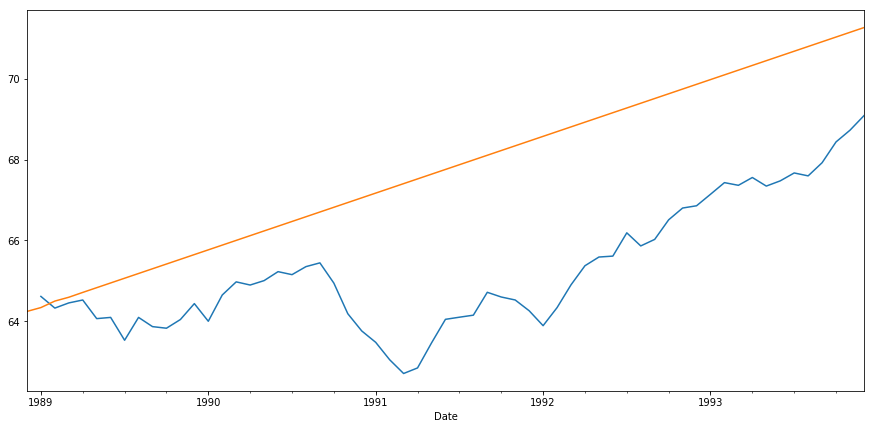

In [51]:
plt.figure(figsize=(15,7))
datatest.Value.plot()
pred = model.predict(start='1988-12-01', end='1993-12-01', typ = 'levels', dynamic = True)
print ('r2_score = ',r2_score(datatest.Value, pred['1989-01-01':]))
pred.plot()
plt.show()

# SARIMAX

In [52]:
model = sm.tsa.statespace.SARIMAX(dataset.Value, order=(2, 1, 7), seasonal_order = (0, 0, 2, 12)).fit(disp = -1)
print ('AIC =', model.aic)

C:\Users\123\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 238.690505775


r2_score =  -0.214936944505


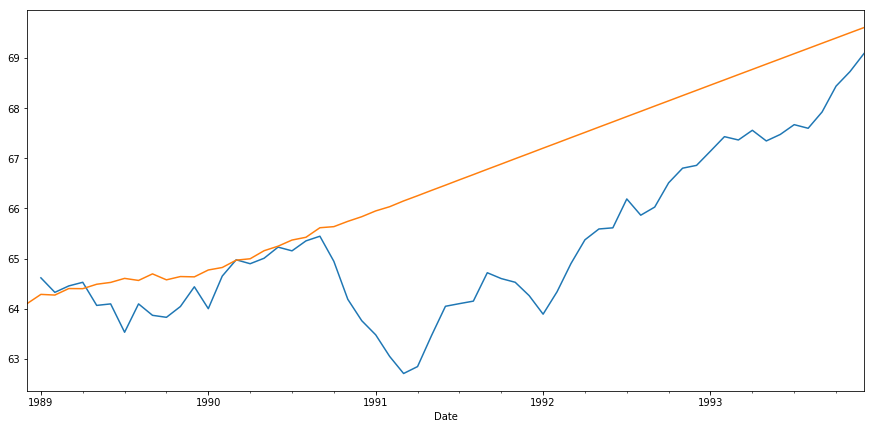

In [53]:
plt.figure(figsize=(15,7))
datatest.Value.plot()
pred = model.predict(start='1988-12-01', end='1993-12-01', typ = 'levels', dynamic = True)
print ('r2_score = ',r2_score(datatest.Value, pred['1989-01-01':]))
pred.plot()
plt.show()

In [54]:
model = sm.tsa.statespace.SARIMAX(dataset.Value, order=(2, 1, 6), seasonal_order = (4, 0, 0, 12)).fit(disp = -1)
print ('AIC =', model.aic)

C:\Users\123\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AIC = 238.967550784


r2_score =  -0.556134928122


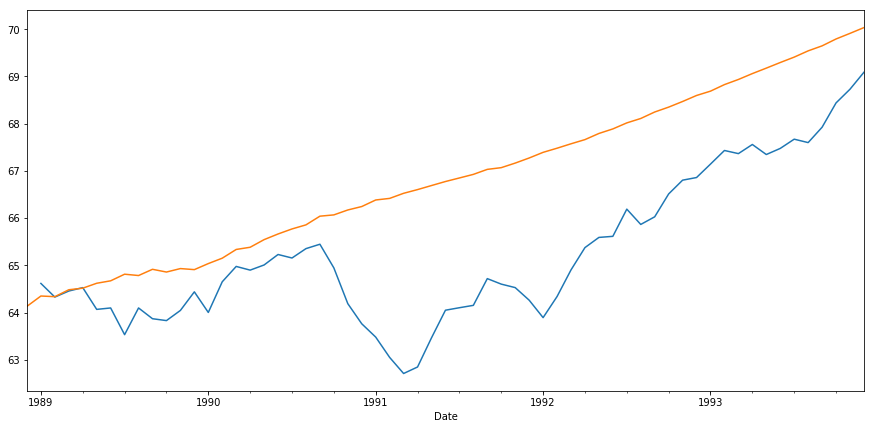

In [55]:
#модель с наименьшим aic. Но её R2_score отрицательный, что говорит о её неадекватности, значит посмотрим модели с меньшим aic
plt.figure(figsize=(15,7))
datatest.Value.plot()
pred = model.predict(start='1988-12-01', end='1993-12-01', typ = 'levels', dynamic = True)
print ('r2_score = ',r2_score(datatest.Value, pred['1989-01-01':]))
pred.plot()
plt.show()

# SARIMAX+COXBOX

In [56]:
dataset['Value_boxcox'], lmbda = stats.boxcox(dataset.Value)

In [57]:
model_boxcox = sm.tsa.statespace.SARIMAX(dataset.Value_boxcox, 
                                      order=(3, 1, 1), 
                                      seasonal_order = (0, 0, 2, 12)).fit(disp = -1)
print ('Model AIC ', model_boxcox.aic)

C:\Users\123\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model AIC  806.968183669


R2 score  0.0761324035324


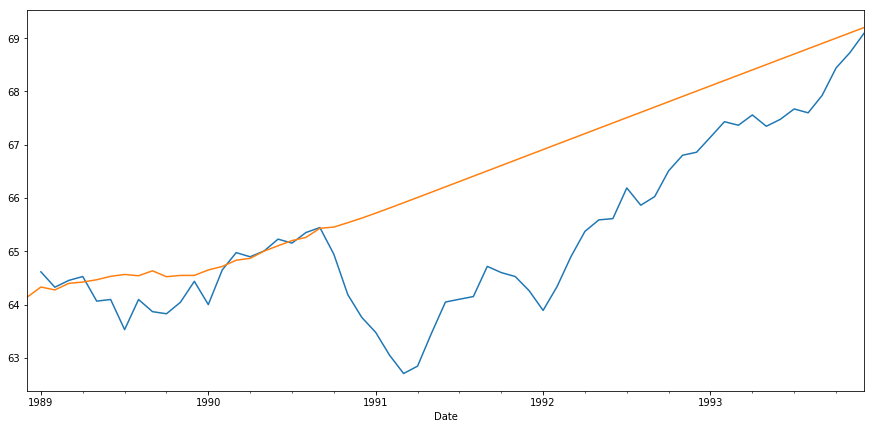

In [58]:
plt.figure(figsize=(15,7))
datatest.Value.plot()
pred_boxcox = invboxcox(model_boxcox.predict(start='1988-12-01', end='1993-12-01', typ = 'levels', dynamic = True), lmbda)
print ('R2 score ', r2_score(datatest.Value, pred_boxcox['1989-01-01':]))
pred_boxcox.plot()
plt.show()

In [59]:
model_boxcox = sm.tsa.statespace.SARIMAX(dataset.Value_boxcox, 
                                      order=(3, 1, 1), 
                                      seasonal_order = (2, 0, 2, 12)).fit(disp = -1)
print ('Model AIC ', model_boxcox.aic)

C:\Users\123\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model AIC  809.963181962


R2 score  0.491871658759


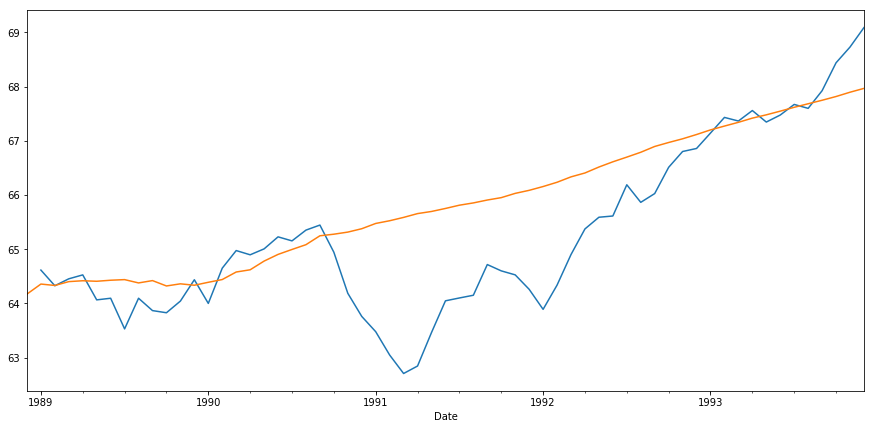

In [60]:
plt.figure(figsize=(15,7))
datatest.Value.plot()
pred_boxcox = invboxcox(model_boxcox.predict(start='1988-12-01', end='1993-12-01', typ = 'levels', dynamic = True), lmbda)
print ('R2 score ', r2_score(datatest.Value, pred_boxcox['1989-01-01':]))
pred_boxcox.plot()
plt.show()

In [61]:
model_boxcox = sm.tsa.statespace.SARIMAX(dataset.Value_boxcox, 
                                      order=(3, 1, 1), 
                                      seasonal_order = (3, 0, 2, 12)).fit(disp = -1)
print ('Model AIC ', model_boxcox.aic)

C:\Users\123\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model AIC  813.46826531


R2 score  0.555985138707


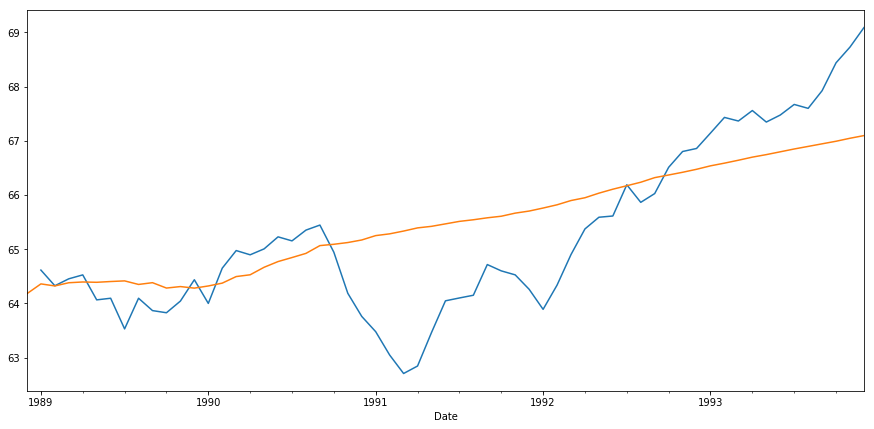

In [62]:
plt.figure(figsize=(15,7))
datatest.Value.plot()
pred_boxcox = invboxcox(model_boxcox.predict(start='1988-12-01', end='1993-12-01', typ = 'levels', dynamic = True), lmbda)
print ('R2 score ', r2_score(datatest.Value, pred_boxcox['1989-01-01':]))
pred_boxcox.plot()
plt.show()